In [338]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [339]:
income_hist_data = pd.read_excel('C:/Users/syedm/Desktop/Stress Testing/Income_Hist_Data.xlsx')
ssad = pd.read_csv('C:/Users/syedm/Desktop/Stress Testing/SupervisorySeverelyAdverseDomestic.csv')

In [340]:
income_hist_data.head()

,Unnamed: 0,institution.name,total.interes.income.reported,total.interest.expense.reported,total.noninterest.income.reported,total.noninterest.expense.reported,provision.losses,tier.1.capital.reported,risk.weighted.assets.reported
0,2015Q4,Citigroup Inc.,14422000,2823000,7160000,11666000,2256000,176420000,1.190853e+09
1,2015Q3,Citigroup Inc.,14771000,2854000,6969000,11190000,1582000,174276000,1.229667e+09
2,2015Q2,Citigroup Inc.,14936000,2938000,7654000,11351000,1515000,173006000,1.253875e+09
3,2015Q1,Citigroup Inc.,14666000,2898000,8041000,11351000,1755000,168021000,1.260403e+09
4,2014Q4,Citigroup Inc.,15324000,3061000,5785000,14833000,1881000,166663000,1.274672e+09


In [341]:
ssad.head()

,Date,Real GDP growth,Nominal GDP growth,Real disposable income growth,Nominal disposable income growth,Unemployment rate,CPI inflation rate,3-month Treasury rate,5-year Treasury yield,10-year Treasury yield,BBB corporate yield,Mortgage rate,Prime rate,Dow Jones Total Stock Market Index (Level),House Price Index (Level),Commercial Real Estate Price Index (Level),Market Volatility Index (Level)
0,Q1 1976,9.3,14.0,4.8,9.5,7.7,4.7,4.9,7.4,7.6,9.4,8.8,6.8,NaN,22.0,51.0,NaN
1,Q2 1976,3.1,7.3,2.1,5.6,7.6,3.6,5.2,7.4,7.6,9.4,8.8,6.9,NaN,22.1,52.0,NaN
2,Q3 1976,2.0,7.4,3.0,9.4,7.7,6.5,5.2,7.3,7.6,9.1,9.0,7.1,NaN,23.1,53.0,NaN
3,Q4 1976,3.0,10.5,2.4,9.0,7.8,5.9,4.7,6.5,7.1,8.8,8.8,6.5,NaN,24.0,53.0,NaN
4,Q1 1977,4.7,11.6,-0.1,7.3,7.5,7.5,4.6,6.8,7.2,8.8,8.7,6.3,NaN,25.0,55.0,NaN


In [342]:
income_hist_data.shape

(172, 9)

In [343]:
# this tells me I can split the data
income_hist_data['institution.name'].value_counts()

institution.name
JPMorgan Chase & Co.    104
Citigroup Inc.           68
Name: count, dtype: int64

In [344]:
# calculating total income, expenses. Doing this before splitting so I don't have to write each line twice
income_hist_data['total.income'] = income_hist_data['total.interes.income.reported'] + income_hist_data['total.noninterest.income.reported']
income_hist_data['total.expense'] = income_hist_data['total.interest.expense.reported'] + income_hist_data['total.noninterest.expense.reported']
income_hist_data['profit'] = income_hist_data['total.income'] - income_hist_data['total.expense']

In [345]:
income_hist_data['Unnamed: 0'].dtype

dtype('O')

In [346]:
income_hist_data['quarter'] = pd.PeriodIndex(income_hist_data['Unnamed: 0'], freq='Q').to_timestamp(how='end')

In [347]:
income_hist_data = income_hist_data.sort_values('quarter')

In [348]:
# split the data by bank, so I can compare them
jpmorgan = income_hist_data[income_hist_data['institution.name']=="JPMorgan Chase & Co."]
citi = income_hist_data[income_hist_data['institution.name']=="Citigroup Inc."]

In [349]:
# check nulls
jpmorgan.isnull().sum()

Unnamed: 0                             0
institution.name                       0
total.interes.income.reported          0
total.interest.expense.reported        0
total.noninterest.income.reported      0
total.noninterest.expense.reported     0
provision.losses                       0
tier.1.capital.reported                0
risk.weighted.assets.reported         40
total.income                           0
total.expense                          0
profit                                 0
quarter                                0
dtype: int64

In [350]:
citi.isnull().sum()

Unnamed: 0                             0
institution.name                       0
total.interes.income.reported          0
total.interest.expense.reported        0
total.noninterest.income.reported      0
total.noninterest.expense.reported     0
provision.losses                       0
tier.1.capital.reported                0
risk.weighted.assets.reported         12
total.income                           0
total.expense                          0
profit                                 0
quarter                                0
dtype: int64

In [351]:
# will impute the nulls here for the sake of this project. In actual work, 40% missing could not be
# fixed like this
jpmorgan['risk.weighted.assets.reported'] = (
    jpmorgan['risk.weighted.assets.reported']
    .fillna(method='ffill')
    .fillna(method='bfill')
)

citi['risk.weighted.assets.reported'] = (
    citi['risk.weighted.assets.reported']
    .fillna(method='ffill')
    .fillna(method='bfill')
)

C:\Users\syedm\AppData\Local\Temp\ipykernel_16348\2970170342.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')
C:\Users\syedm\AppData\Local\Temp\ipykernel_16348\2970170342.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
C:\Users\syedm\AppData\Local\Temp\ipykernel_16348\2970170342.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jpmorgan['risk.weighted.assets.reported'] = (
C:\Users\syedm\AppData\Local\Temp\ipykernel_16348\2970170342.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a 

In [352]:
# capital ratio
jpmorgan['capital_ratio'] = jpmorgan['tier.1.capital.reported'] / jpmorgan['risk.weighted.assets.reported']
citi['capital_ratio'] = citi['tier.1.capital.reported'] / citi['risk.weighted.assets.reported']

C:\Users\syedm\AppData\Local\Temp\ipykernel_16348\1259853592.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jpmorgan['capital_ratio'] = jpmorgan['tier.1.capital.reported'] / jpmorgan['risk.weighted.assets.reported']
C:\Users\syedm\AppData\Local\Temp\ipykernel_16348\1259853592.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citi['capital_ratio'] = citi['tier.1.capital.reported'] / citi['risk.weighted.assets.reported']


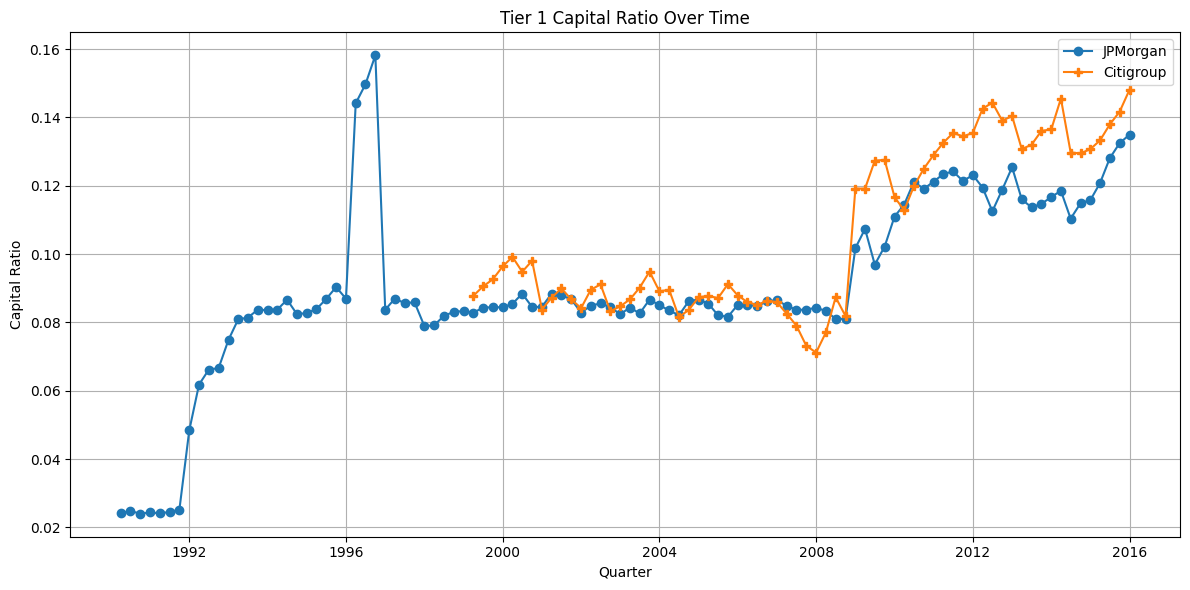

In [353]:
plt.figure(figsize=(12, 6))

plt.plot(jpmorgan['quarter'], jpmorgan['capital_ratio'], label="JPMorgan", marker='o')
plt.plot(citi['quarter'], citi['capital_ratio'], label="Citigroup", marker='P')

plt.title("Tier 1 Capital Ratio Over Time")
plt.xlabel("Quarter")
plt.ylabel("Capital Ratio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [354]:
ssad['quarter_str'] = ssad['Date'].apply(lambda x: f"{x.split()[1]}{x.split()[0]}")

ssad['quarter'] = pd.PeriodIndex(ssad['quarter_str'], freq='Q').to_timestamp(how='end')

In [355]:
jpm_merged = jpmorgan.merge(ssad, on='quarter', how='inner')
citi_merged = citi.merge(ssad, on='quarter', how='inner')

In [356]:
predictors = [
    "Real GDP growth",
    "Unemployment rate",
    "CPI inflation rate",
    "Mortgage rate",
    "3-month Treasury rate",
    "Market Volatility Index (Level)"
]

jpm_data = jpm_merged.dropna(subset=predictors + ['profit'])
X = jpm_data[predictors]
y = jpm_data['profit']

X = sm.add_constant(X)

modeljpm = sm.OLS(y, X).fit()
print(modeljpm.summary())


                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     38.78
Date:                Tue, 19 Aug 2025   Prob (F-statistic):           1.07e-23
Time:                        00:17:14   Log-Likelihood:                -1653.4
No. Observations:                 104   AIC:                             3321.
Df Residuals:                      97   BIC:                             3339.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [357]:
citi_data = citi_merged.dropna(subset=predictors + ['profit'])
X = citi_data[predictors]
y = citi_data['profit']

X = sm.add_constant(X)

modelciti = sm.OLS(y, X).fit()
print(modelciti.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     2.100
Date:                Tue, 19 Aug 2025   Prob (F-statistic):             0.0661
Time:                        00:17:14   Log-Likelihood:                -1139.1
No. Observations:                  68   AIC:                             2292.
Df Residuals:                      61   BIC:                             2308.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [358]:
#based on this output, while JP Morgan is impacted by many variables, Citi is surprisingly undisturbed for
# the most part. Also, JP Morgan seems to do better when unemployment increases.
# the next step is to test if Citi has a lag.

In [359]:
ssad_lagged = ssad.copy()
ssad_lagged[['Real GDP growth', 'Unemployment rate', 'CPI inflation rate',
             'Mortgage rate', '3-month Treasury rate', 'Market Volatility Index (Level)']] = \
    ssad_lagged[['Real GDP growth', 'Unemployment rate', 'CPI inflation rate',
                 'Mortgage rate', '3-month Treasury rate', 'Market Volatility Index (Level)']].shift(1)
citi_merged_lagged = citi.merge(ssad_lagged, on='quarter', how='inner')

In [360]:
X_lagged = citi_merged_lagged[[
    'Real GDP growth', 'Unemployment rate', 'CPI inflation rate',
    'Mortgage rate', '3-month Treasury rate', 'Market Volatility Index (Level)'
]]
y = citi_merged_lagged['profit']
X_lagged = sm.add_constant(X_lagged)

model_lagged = sm.OLS(y, X_lagged).fit()
print(model_lagged.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     3.130
Date:                Tue, 19 Aug 2025   Prob (F-statistic):            0.00969
Time:                        00:17:14   Log-Likelihood:                -1136.4
No. Observations:                  68   AIC:                             2287.
Df Residuals:                      61   BIC:                             2302.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [361]:
# the lag improved the results but not by much. We'll assume other factors have a larger impact on Citi

In [362]:
#checking multicollinearity
X = sm.add_constant(jpm_data[predictors])
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                           Feature        VIF
0                            const  64.190931
1                  Real GDP growth   1.292945
2                Unemployment rate   1.928450
3               CPI inflation rate   1.328133
4                    Mortgage rate   5.799836
5            3-month Treasury rate   7.886794
6  Market Volatility Index (Level)   1.414565


In [363]:
# Based on this output, its worth checking the 3 month treasury rate. In this case, I will just accept it
# and move forward, since its not too high

In [364]:
# We will now design two stress scenarios, moderate and severe.
# We will then predict JP Morgan profit under these two scenarios

# Moderate scenario
moderate = pd.DataFrame({
    'const': [1],
    'Real GDP growth': [-1.0],
    'Unemployment rate': [6.5],
    'CPI inflation rate': [3.0],
    'Mortgage rate': [6.0],
    '3-month Treasury rate': [2.0],
    'Market Volatility Index (Level)': [35]
})

# Severe scenario
severe = pd.DataFrame({
    'const': [1],
    'Real GDP growth': [-6.0],
    'Unemployment rate': [10.0],
    'CPI inflation rate': [2.0],
    'Mortgage rate': [7.5],
    '3-month Treasury rate': [0.25],
    'Market Volatility Index (Level)': [55]
})

In [365]:
# predict profit as defined by net income - net expenses using our regression model
mod_profit = modeljpm.predict(moderate)[0]
sev_profit = modeljpm.predict(severe)[0]

print(f" JP Morgan Moderate stress profit: ${mod_profit:,.0f}")
print(f"JP Morgan Severe stress profit: ${sev_profit:,.0f}")

 JP Morgan Moderate stress profit: $5,344,435
JP Morgan Severe stress profit: $3,712,920


In [366]:
mod_profit_citi = modelciti.predict(moderate)[0]
sev_profit_citi = modelciti.predict(severe)[0]

print(f"Citi Moderate Stress Profit: ${mod_profit_citi:,.0f}")
print(f"Citi Severe Stress Profit: ${sev_profit_citi:,.0f}")

Citi Moderate Stress Profit: $5,100,894
Citi Severe Stress Profit: $4,040,989


In [367]:
def calculate_stress_capital_ratios(df, mod_profit, sev_profit):
    current_tier1 = df['tier.1.capital.reported'].iloc[-1]
    current_rwa = df['risk.weighted.assets.reported'].iloc[-1]

    tier1_moderate = current_tier1 + mod_profit
    tier1_severe = current_tier1 + sev_profit

    baseline_ratio = current_tier1 / current_rwa
    moderate_ratio = tier1_moderate / current_rwa
    severe_ratio = tier1_severe / current_rwa

    return baseline_ratio, moderate_ratio, severe_ratio

# JPMorgan
calculate_stress_capital_ratios(jpmorgan, mod_profit, sev_profit)

# Citi
calculate_stress_capital_ratios(citi, mod_profit_citi, sev_profit_citi)

(0.14814588571793938, 0.15242928031851904, 0.15153924168206828)

In [368]:
jpm_baseline, jpm_mod, jpm_sev = calculate_stress_capital_ratios(jpmorgan, mod_profit, sev_profit)
citi_baseline, citi_mod, citi_sev = calculate_stress_capital_ratios(citi, mod_profit_citi, sev_profit_citi)

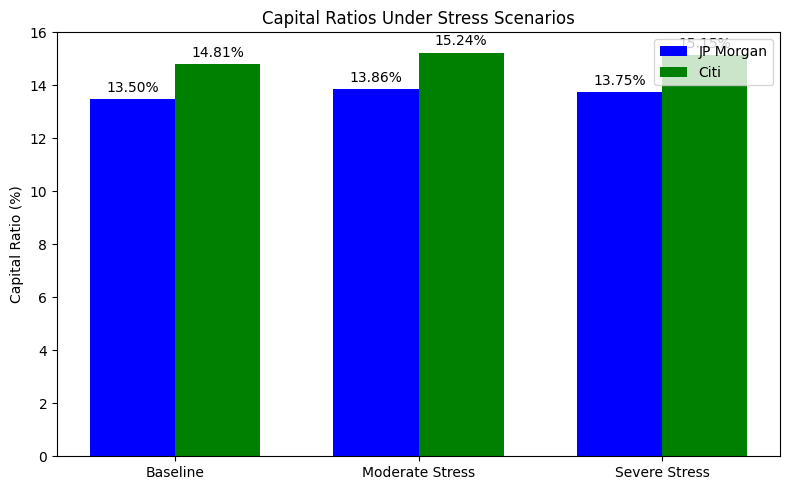

In [369]:
def plot_capital_ratios(jpm_ratios, citi_ratios):
    import matplotlib.pyplot as plt
    import numpy as np

    labels = ['Baseline', 'Moderate Stress', 'Severe Stress']
    jpm_values = [r * 100 for r in jpm_ratios]
    citi_values = [r * 100 for r in citi_ratios]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    bars1 = ax.bar(x - width/2, jpm_values, width, label='JP Morgan', color='blue')
    bars2 = ax.bar(x + width/2, citi_values, width, label='Citi', color='green')

    ax.set_ylabel('Capital Ratio (%)')
    ax.set_title('Capital Ratios Under Stress Scenarios')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

jpm_ratios = (jpm_baseline, jpm_mod, jpm_sev)
citi_ratios = (citi_baseline, citi_mod, citi_sev)

plot_capital_ratios(jpm_ratios, citi_ratios)

In [370]:
# Reverse Stress Testing

capital_ratio_threshold = 0.12

gdp_range = np.linspace(-6, 2, 9) # from -6% to +2%
unemp_range = np.linspace(4, 12, 9) # from 4% to 12%
cpi_range = np.linspace(0, 6, 7) # from 0% to 6%
mortgage_range = np.linspace(3, 8, 6) # from 3% to 8%
treasury_range = np.linspace(0, 5, 6) # from 0% to 5%
vix_range = np.linspace(15, 60, 10) # VIX level from 15 to 60

In [371]:
from itertools import product

def reverse_stress_test(model, bank_df, threshold=0.12):
    tier1 = bank_df['tier.1.capital.reported'].iloc[-1]
    rwa = bank_df['risk.weighted.assets.reported'].iloc[-1]

    results = []

    for gdp, unemp, cpi, mort, t_bill, vix in product(gdp_range, unemp_range, cpi_range, mortgage_range, treasury_range, vix_range):
        input_df = pd.DataFrame([{
            'const': 1,
            'Real GDP growth': gdp,
            'Unemployment rate': unemp,
            'CPI inflation rate': cpi,
            'Mortgage rate': mort,
            '3-month Treasury rate': t_bill,
            'Market Volatility Index (Level)': vix
        }])

        profit = model.predict(input_df)[0]
        capital_ratio = (tier1 + profit) / rwa

        if capital_ratio < threshold:
            results.append({
                'GDP': gdp,
                'Unemployment': unemp,
                'CPI': cpi,
                'Mortgage': mort,
                'Treasury': t_bill,
                'VIX': vix,
                'Predicted Profit': profit,
                'Capital Ratio': capital_ratio
            })

    return pd.DataFrame(results)

In [372]:
risky_jpm = reverse_stress_test(modeljpm, jpmorgan)
risky_citi = reverse_stress_test(modelciti, citi)

def summarize_reverse_stress_results(results_df, bank_name):
    if results_df.empty:
        print(f"No scenarios found where {bank_name}'s capital ratio drops below the threshold.")
        return
    
    print(f"Number of risky scenarios for {bank_name}: {len(results_df)}")
    
    worst = results_df.loc[results_df['Capital Ratio'].idxmin()]
    print(f"Worst Case Scenario for {bank_name}:")
    print(f"Capital Ratio: {worst['Capital Ratio']:.2%}")
    print(f"GDP: {worst['GDP']}%")
    print(f"Unemployment: {worst['Unemployment']}%")
    print(f"CPI: {worst['CPI']}%")
    print(f"Mortgage Rate: {worst['Mortgage']}%")
    print(f"3M Treasury: {worst['Treasury']}%")
    print(f"VIX: {worst['VIX']}")
    print(f"Predicted Profit: ${worst['Predicted Profit']:,.0f}")
    
    # Macro pattern insights
    print(f"Common Conditions Across Risky Scenarios:")
    print(results_df.describe()[['GDP', 'Unemployment', 'CPI', 'Mortgage', 'Treasury', 'VIX']])

In [373]:
risky_jpm = reverse_stress_test(modeljpm, jpmorgan)
risky_citi = reverse_stress_test(modelciti, citi)

In [374]:
summarize_reverse_stress_results(risky_jpm, "JP Morgan")
summarize_reverse_stress_results(risky_citi, "Citi")

No scenarios found where JP Morgan's capital ratio drops below the threshold.
No scenarios found where Citi's capital ratio drops below the threshold.
